In [3]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import sys
import seaborn as sns
from pandas import DataFrame
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
mpl.rc('image', cmap='Pastel1')
np.random.seed(42)
import dill

In [4]:
# set matplotlib font sizes
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# load old ipython state
dill.load_session('Method_eval.db')

In [3]:
# load processed dataset
whole_df = pd.read_csv("/Users/jozef/Jupyter/Signal Processing/DBS/data/all_features.csv")

In [4]:
import random

class CustomSplitter():
    """
    Custom cross-validation splitter class.
    Splitter returns a test set of one DBS-on block and one DBS-off block.
    The rest of the blocks are used for the training data
    """
    def __init__(self):
        pass

    def split(self, X):
        """
        Split the data in train and test sets.
        
        @param X: pandas DataFrame containing at least the columns 'stim' and 'ix_block'
        @return splits: list of train, test index tuples
        """
        on_blocks = X[X['stim'] == 1]['ix_block'].unique()
        off_blocks = X[X['stim'] == 0]['ix_block'].unique()
        
        splits = []
        n_splits = min(len(on_blocks), len(off_blocks))
        
        for i in range(n_splits):            
            
            test_index = np.where(X['ix_block'] == on_blocks[i])
            test_index = np.append(test_index, np.where(X['ix_block'] == off_blocks[i]))
            
            train_index = [x for x in np.arange(len(X)) if x not in test_index]
            
            splits.append((train_index, test_index))
            
        return splits
        

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer

def hyperparam_opt(df, pipeline, params, transform = False):
    """
    Function that evaluates a method using a nested crossvalidation procedure in which the inner 
    loop performs a grid search over the specified hyperparameters

    @param df: pandas DataFrame containing the data
    @param pipeline: sklearn Pipeline containing the method
    @param params: dictionary of the hyperparameter ranges used in the grid search
    @param transform: boolean to control whether we use the transform function or predict_proba only 
    neccessary for the baseline LDA

    @return results: pandas DataFrame containing the scores generated by the validation procedure
    @return searches: dictionary containing the GridSearchCV classes of every fold. 
    """
    validation_scores = {}
    holdout_scores = {}
    best_params = {}
    searches = {}   
    
    for name, group in df.groupby('session'):
        print("\n------------------------------------------------------------------")
        print('Session %2d' % name)

        on_blocks = group[group['stim'] == 1]['ix_block'].unique()
        off_blocks = group[group['stim'] == 0]['ix_block'].unique()

        valid_holdout_count = min(len(on_blocks), len(off_blocks))

        holdout_scores[name] = []
        validation_scores[name] = []
        best_params[name] = []
        searches[name] = []
        
        print("testing %d rounds" %valid_holdout_count)

        for k in range(valid_holdout_count):
            
            # create holdout data
            holdout_blocks = [on_blocks[k], off_blocks[k]]

            holdout_data = group[group['ix_block'].isin(holdout_blocks)]
            holdout_X = holdout_data.drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp'], axis =1)
            holdout_y = holdout_data['stim']
            
            # create data for inner loop of cross-validation
            valid_data = group[~group['ix_block'].isin(holdout_blocks)]
            X = valid_data.drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp'], axis =1)
            y = valid_data['stim']
            valid_data.reset_index(drop=True, inplace=True)
            
            # run grid search
            kf = CustomSplitter()

            gscv = GridSearchCV(pipeline, params, cv = kf.split(valid_data), 
                                scoring = make_scorer(roc_auc_score, needs_proba=True), 
                                verbose = 1, n_jobs = -1)

            search = gscv.fit(X,y)       
            
            best_params[name].append(search.best_params_)
            validation_scores[name].append(search.best_score_)
            searches[name].append(search)            
            
            # score on holdout data
            if transform:
                if np.mean(search.transform(X[y==0])) > np.mean(search.transform(X[y==1])):          
                    holdout_scores[name].append(roc_auc_score((holdout_y  *-1) + 1, search.transform(holdout_X)))
                else:
                    holdout_scores[name].append(roc_auc_score(holdout_y, search.transform(holdout_X)))
            else:
                holdout_scores[name].append(roc_auc_score(holdout_y, search.predict_proba(holdout_X)[:,1] ))
            
            
            print(search.best_params_)

        print(validation_scores[name])
        print(holdout_scores[name])
    
    # create results DataFrame
    data = {'session': [], 'validation_scores': [], 'holdout_scores': [], 'best_params': []}
    
    for i in df['session'].unique():
        data['session'].append(i)
        data['validation_scores'].append(validation_scores[i])
        data['holdout_scores'].append(holdout_scores[i])    
        data['best_params'].append(best_params[i])
        
    results = pd.DataFrame(data)
    
    return results, searches

In [7]:
def get_best_params(searches):
    """
    Function that extracts the best performing hyperparameters per session
    
    @params searches: dictionary of lists of GridSearchCV classes
    
    @return best_params: dictionary of best parameters per session
    """
    best_params = {}
    
    for sesh in range(2,8):
        scores = np.ones_like(searches[sesh][0].cv_results_['mean_test_score'])
        for i in range(len(searches[sesh])):
            scores = scores + searches[sesh][i].cv_results_['mean_test_score']
        
        score_df = pd.DataFrame(data = {'params': searches[sesh][0].cv_results_['params'], 
                                        'scores': scores})
        
        max_score = max(score_df['scores'])
        
        best_params[sesh] = score_df[score_df['scores'] == max_score]['params'].iloc[0]
    return best_params

# Hyperparameter optimization

## standard data

In [9]:
# test SVC on standard data-set
pipeline = Pipeline([('standardize', StandardScaler()),
                                     ('classifier', SVC(probability = True, random_state = 42))])

params = {"classifier__C" : [0.0001, 0.001, 0.01, 0.1, 1.0, 10], 
                   "classifier__gamma": [0.0001, 0.001, 0.01, 0.1, 1.0, 10]} 

standard_svc, standard_svc_searches = hyperparam_opt(whole_df, pipeline, params)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 1.0, 'classifier__gamma': 0.0001}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 0.1, 'classifier__gamma': 0.1}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 0.1, 'classifier__gamma': 0.01}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 0.1, 'classifier__gamma': 0.001}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 10, 'classifier__gamma': 0.001}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 10, 'classifier__gamma': 0.1}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 10, 'classifier__gamma': 0.1}
[0.5474537037037037, 0.5497685185185185, 0.6290509259259259, 0.5457175925925926, 0.5324074074074074, 0.5179398148148148, 0

In [10]:
# test random forest on standard data-set
pipeline = Pipeline([('classifier', RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators=128))])

params = {'classifier__criterion': ['gini', 'entropy'],
          'classifier__max_features': ['sqrt', 0.2, 0.3, 0.4, 0.8],
          'classifier__max_samples': [0.2, 0.4, 0.6, 0.8, None]
         }

standard_rf, standard_rf_searches = hyperparam_opt(whole_df, pipeline, params)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'gini', 'classifier__max_features': 0.2, 'classifier__max_samples': None}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'gini', 'classifier__max_features': 0.8, 'classifier__max_samples': 0.6}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'entropy', 'classifier__max_features': 0.8, 'classifier__max_samples': 0.8}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt', 'classifier__max_samples': 0.2}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'gini', 'classifier__max_features': 0.2, 'classifier__max_samples': 0.2}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': '

{'classifier__criterion': 'gini', 'classifier__max_features': 0.3, 'classifier__max_samples': 0.6}
Fitting 7 folds for each of 50 candidates, totalling 350 fits
{'classifier__criterion': 'entropy', 'classifier__max_features': 0.2, 'classifier__max_samples': 0.4}
[0.7667297979797981, 0.7043650793650794, 0.6429473304473305, 0.5985299422799423, 0.6655844155844155, 0.6585497835497837, 0.7191107503607503, 0.6654942279942281]
[0.3819444444444444, 0.643939393939394, 0.7847222222222222, 0.8854166666666666, 0.6180555555555556, 0.6875, 0.4965277777777778, 0.65625]


In [26]:
# test LDA on standard data-set
pipeline = Pipeline([('standardize', StandardScaler()),
                                     ('classifier', LDA())])

params = {"classifier__solver" : ['lsqr', 'eigen'], 
           "classifier__shrinkage": ['auto', None]} 

standard_lda, standard_lda_searches = hyperparam_opt(whole_df, pipeline, params)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
[0.5601851851851852, 0.6157407407407408, 0.50347

In [12]:
# test logistic regression on standard data-set
pipeline = Pipeline([('standardize', StandardScaler()),
                             ('classifier', LogisticRegression())])

params = [{"classifier__solver" : ['newton-cg'], 
           "classifier__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10],
         }]

standard_lr, standard_lr_searches = hyperparam_opt(whole_df, pipeline, params)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 1.0, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 0.01, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 0.0001, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
[0.5671296296296297, 0.5706018518518517, 0.4895833333333333, 0.482638888888888

In [13]:
# test baseline LDA on standard data-set
pipeline = Pipeline([('standardize', StandardScaler()),
                             ('classifier', LDA())])

params = {"classifier__solver" : ['eigen'], 
           "classifier__shrinkage": ['auto']}

standard_lda_transform, standard_lda_transform_searches = hyperparam_opt(whole_df, pipeline, params, transform = True)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
[0.5231481481481483, 0.5, 0.47800925

In [14]:
# aggregate results on standard dataset
data = {'session': [2,3,4,5,6,7], 
        'LDA': pd.DataFrame(standard_lda['holdout_scores'].values.tolist()).mean(1),
       'Logistic Regression': pd.DataFrame(standard_lr['holdout_scores'].values.tolist()).mean(1),
       'Random Forest': pd.DataFrame(standard_rf['holdout_scores'].values.tolist()).mean(1),
       'SVC': pd.DataFrame(standard_svc['holdout_scores'].values.tolist()).mean(1),
       'Baseline LDA': pd.DataFrame(standard_lda_transform['holdout_scores'].values.tolist()).mean(1)
       }

standard_holdout_results = pd.DataFrame(data)
standard_holdout_results

,session,LDA,Logistic Regression,Random Forest,SVC,Baseline LDA
0,2,0.512897,0.454365,0.525794,0.379464,0.451389
1,3,0.840278,0.813889,0.830556,0.866667,0.809722
2,4,0.774306,0.780093,0.848958,0.752315,0.782407
3,5,0.869792,0.853299,0.860243,0.840278,0.875000
4,6,0.949044,0.913330,0.909091,0.915133,0.946158
5,7,0.701073,0.730429,0.644295,0.769137,0.557055


In [40]:
# save raw scores on holdout sets
data = {'LDA': np.hstack(standard_lda['holdout_scores'].values.tolist()[1:]),
       'Logistic Regression': np.hstack(standard_lr['holdout_scores'].values.tolist()[1:]),
       'Random Forest': np.hstack(standard_rf['holdout_scores'].values.tolist()[1:]),
       'SVC': np.hstack(standard_svc['holdout_scores'].values.tolist()[1:]),
       'Baseline LDA': np.hstack(standard_lda_transform['holdout_scores'].values.tolist()[1:])
       }

raw_standard_scores = pd.DataFrame(data)
raw_standard_scores.to_csv('data/raw_standard_scores.csv', index=False)

In [3]:
standard_holdout_results[1:].mean()

session                5.000000
LDA                    0.826898
Logistic Regression    0.818208
Random Forest          0.818628
SVC                    0.828706
Baseline LDA           0.794069
dtype: float64

## detrended data

In [16]:
#Data detrending
from sklearn.linear_model import LinearRegression

detrended_df = pd.DataFrame(columns = whole_df.columns)
feats = whole_df.drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp'], axis =1).columns

# fit linear regression on each feature and timestamps and remove linear trend from the data.
for name, group in whole_df.groupby('session'):
    tstamps = np.array(group['startTStamp']).reshape(-1, 1)
    for feat in feats:       
        c_model_detrend = LinearRegression().fit(tstamps, group[feat])
        group[feat] -= c_model_detrend.predict(tstamps)
    
    detrended_df = detrended_df.append(group, ignore_index = True) 
detrended_df['stim'] = detrended_df['stim'].astype('int')

In [18]:
# test SVC on detrended data-set
pipeline = Pipeline([('standardize', StandardScaler()),
                                     ('classifier', SVC(probability = True, random_state = 42))])

params = {"classifier__C" : [0.0001, 0.001, 0.01, 0.1, 1.0, 10], 
                   "classifier__gamma": [0.0001, 0.001, 0.01, 0.1, 1.0, 10]} 

detrended_svc, detrended_svc_searches  = hyperparam_opt(detrended_df, pipeline, params)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 1.0, 'classifier__gamma': 0.001}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 10, 'classifier__gamma': 0.0001}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 0.1, 'classifier__gamma': 0.01}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 1.0, 'classifier__gamma': 0.001}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 10, 'classifier__gamma': 0.001}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 10, 'classifier__gamma': 0.1}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 10, 'classifier__gamma': 0.1}
[0.5677083333333334, 0.568287037037037, 0.6464120370370371, 0.5844907407407407, 0.5277777777777778, 0.5434027777777778, 0

In [19]:
# test random forest on detrended data-set
pipeline = Pipeline([('classifier', RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators=128))])

params = {'classifier__criterion': ['gini', 'entropy'],
          'classifier__max_features': ['sqrt', 0.2, 0.3, 0.4, 0.8],
          'classifier__max_samples': [0.2, 0.4, 0.6, 0.8, None]
         }

detrended_rf, detrended_rf_searches = hyperparam_opt(detrended_df, pipeline, params)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'gini', 'classifier__max_features': 0.3, 'classifier__max_samples': 0.6}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'gini', 'classifier__max_features': 0.8, 'classifier__max_samples': None}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt', 'classifier__max_samples': None}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'gini', 'classifier__max_features': 0.4, 'classifier__max_samples': 0.8}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'entropy', 'classifier__max_features': 0.2, 'classifier__max_samples': None}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion':

{'classifier__criterion': 'entropy', 'classifier__max_features': 0.2, 'classifier__max_samples': 0.8}
Fitting 7 folds for each of 50 candidates, totalling 350 fits
{'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt', 'classifier__max_samples': 0.4}
[0.7819715007215008, 0.6969246031746031, 0.6688311688311688, 0.6242334054834054, 0.7145562770562771, 0.6587752525252525, 0.707115800865801, 0.6927759740259739]
[0.3159722222222222, 0.7159090909090908, 0.7048611111111112, 0.9027777777777778, 0.6631944444444444, 0.75, 0.5902777777777778, 0.6770833333333333]


In [20]:
# test LDA on detrended data-set
pipeline = Pipeline([('standardize', StandardScaler()),
                                     ('classifier', LDA())])

params = {"classifier__solver" : ['lsqr', 'eigen'], 
           "classifier__shrinkage": ['auto', None]} 

detrended_lda, detrended_lda_searches = hyperparam_opt(detrended_df, pipeline, params)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
[0.5983796296296297, 0.6493055555555555, 0.5173611

In [21]:
# test logistic regression on detrended data-set
pipeline = Pipeline([('standardize', StandardScaler()),
                             ('classifier', LogisticRegression())])

params = [{"classifier__solver" : ['newton-cg'], 
           "classifier__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10],
         }]

detrended_lr, detrended_lr_searches = hyperparam_opt(detrended_df, pipeline, params)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 1.0, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 0.1, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 0.0001, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
[0.5694444444444443, 0.5810185185185185, 0.48611111111111116, 0.506944444444444

In [22]:
# test baseline LDA on detrended data-set
pipeline = Pipeline([('standardize', StandardScaler()),
                             ('classifier', LDA())])

params = {"classifier__solver" : ['eigen'], 
           "classifier__shrinkage": ['auto']}

detrended_lda_transform, detrended_lda_transform_searches = hyperparam_opt(detrended_df, pipeline, params, transform = True)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
[0.5231481481481483, 0.4895833333333

In [23]:
# aggregate results on the detrended data-set
data = {'session': [2,3,4,5,6,7], 
        'LDA': pd.DataFrame(detrended_lda['holdout_scores'].values.tolist()).mean(1),
       'Logistic Regression': pd.DataFrame(detrended_lr['holdout_scores'].values.tolist()).mean(1),
       'Random Forest': pd.DataFrame(detrended_rf['holdout_scores'].values.tolist()).mean(1),
       'SVC': pd.DataFrame(detrended_svc['holdout_scores'].values.tolist()).mean(1),
       'LDA transform': pd.DataFrame(detrended_lda_transform['holdout_scores'].values.tolist()).mean(1)}

detrend_holdout_results = pd.DataFrame(data)
detrend_holdout_results

,session,LDA,Logistic Regression,Random Forest,SVC,LDA transform
0,2,0.597222,0.461310,0.559524,0.429067,0.432540
1,3,0.825000,0.822222,0.855556,0.851389,0.806944
2,4,0.767361,0.800926,0.818866,0.809028,0.776620
3,5,0.854167,0.829861,0.837240,0.840278,0.860243
4,6,0.917929,0.883297,0.909181,0.876443,0.920905
5,7,0.707939,0.728614,0.665009,0.796875,0.530224


In [24]:
detrend_holdout_results.mean()

session                4.500000
LDA                    0.778270
Logistic Regression    0.754372
Random Forest          0.774229
SVC                    0.767180
LDA transform          0.721246
dtype: float64

## sub-trial data

In [25]:
sub_trial_df = pd.read_csv("/Users/jozef/Jupyter/Signal Processing/DBS/data/all_features_sub_trial.csv")

In [27]:
# test SVC on the sub-trial data-set
pipeline = Pipeline([('standardize', StandardScaler()),
                                     ('classifier', SVC(probability = True, random_state = 42))])

params = {"classifier__C" : [0.0001, 0.001, 0.01, 0.1, 1.0, 10], 
                   "classifier__gamma": [0.0001, 0.001, 0.01, 0.1, 1.0, 10]} 

sub_trial_svc, sub_trial_svc_searches = hyperparam_opt(sub_trial_df, pipeline, params)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 1.0, 'classifier__gamma': 0.0001}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 10, 'classifier__gamma': 0.001}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 0.1, 'classifier__gamma': 0.01}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 0.0001, 'classifier__gamma': 0.0001}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 10, 'classifier__gamma': 0.1}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 10, 'classifier__gamma': 0.1}
Fitting 6 folds for each of 36 candidates, totalling 216 fits
{'classifier__C': 0.0001, 'classifier__gamma': 0.0001}
[0.5731095679012346, 0.5490612139917697, 0.6335519547325102, 0.5823045267489713, 0.5448173868312757, 0.554269547

In [28]:
# test random forest on the sub-trial data-set
pipeline = Pipeline([('classifier', RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators=128))])

params = {'classifier__criterion': ['gini', 'entropy'],
          'classifier__max_features': ['sqrt', 0.2, 0.3, 0.4, 0.8],
          'classifier__max_samples': [0.2, 0.4, 0.6, 0.8, None]
         }

sub_trial_rf, sub_trial_rf_searches = hyperparam_opt(sub_trial_df, pipeline, params)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'gini', 'classifier__max_features': 0.2, 'classifier__max_samples': 0.4}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'gini', 'classifier__max_features': 0.8, 'classifier__max_samples': 0.8}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'entropy', 'classifier__max_features': 0.8, 'classifier__max_samples': None}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'entropy', 'classifier__max_features': 0.2, 'classifier__max_samples': 0.4}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'gini', 'classifier__max_features': 0.8, 'classifier__max_samples': 0.8}
Fitting 6 folds for each of 50 candidates, totalling 300 fits
{'classifier__criterion': 'ent

{'classifier__criterion': 'gini', 'classifier__max_features': 0.2, 'classifier__max_samples': 0.2}
Fitting 7 folds for each of 50 candidates, totalling 350 fits
{'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt', 'classifier__max_samples': 0.2}
[0.6850549142215809, 0.6245590828924162, 0.6283319304152638, 0.5785283389450057, 0.6752094356261024, 0.6154451258617925, 0.6475318662818663, 0.6422007776174442]
[0.4448302469135803, 0.6574074074074073, 0.6277006172839507, 0.8869598765432098, 0.5405092592592593, 0.7006172839506173, 0.5061728395061729, 0.5100308641975309]


In [29]:
# test LDA on the sub-trial data-set
pipeline = Pipeline([('standardize', StandardScaler()),
                                     ('classifier', LDA())])

params = {"classifier__solver" : ['lsqr', 'eigen'], 
           "classifier__shrinkage": ['auto', None]} 

sub_trial_lda, sub_trial_lda_searches = hyperparam_opt(sub_trial_df, pipeline, params)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'classifier__shrinkage': None, 'classifier__solver': 'lsqr'}
[0.5630144032921811, 0.5896347736625515, 0.4980709

In [30]:
# test logistic regression on the sub-trial data-set
pipeline = Pipeline([('standardize', StandardScaler()),
                             ('classifier', LogisticRegression())])

params = [{"classifier__solver" : ['newton-cg'], 
           "classifier__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10],
         }]

sub_trial_lr, sub_trial_lr_searches = hyperparam_opt(sub_trial_df, pipeline, params)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 0.0001, 'classifier__solver': 'newton-cg'}
Fitting 6 folds for each of 6 candidates, totalling 36 fits
{'classifier__C': 10, 'classifier__solver': 'newton-cg'}
[0.5532407407407408, 0.5834619341563786, 0.5054012345679012, 0.5019290123456789, 

In [31]:
# test baseline LDA on the sub-trial data-set
pipeline = Pipeline([('standardize', StandardScaler()),
                             ('classifier', LDA())])

params = {"classifier__solver" : ['eigen'], 
           "classifier__shrinkage": ['auto']}

sub_trial_lda_transform, sub_trial_lda_searches = hyperparam_opt(sub_trial_df, pipeline, params, transform = True)


------------------------------------------------------------------
Session  2
testing 7 rounds
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
Fitting 6 folds for each of 1 candidates, totalling 6 fits
{'classifier__shrinkage': 'auto', 'classifier__solver': 'eigen'}
[0.48366769547325106, 0.529578189300

In [32]:
# aggregate sub trial results
data = {'session': [2,3,4,5,6,7], 
        'LDA': pd.DataFrame(sub_trial_lda['holdout_scores'].values.tolist()).mean(1),
       'Logistic Regression': pd.DataFrame(sub_trial_lr['holdout_scores'].values.tolist()).mean(1),
       'Random Forest': pd.DataFrame(sub_trial_rf['holdout_scores'].values.tolist()).mean(1),
       'SVC': pd.DataFrame(sub_trial_svc['holdout_scores'].values.tolist()).mean(1),
       'LDA transform': pd.DataFrame(sub_trial_lda_transform['holdout_scores'].values.tolist()).mean(1)}

sub_trial_holdout_results = pd.DataFrame(data)
sub_trial_holdout_results


,session,LDA,Logistic Regression,Random Forest,SVC,LDA transform
0,2,0.534943,0.499890,0.541005,0.472388,0.407187
1,3,0.816204,0.795679,0.779321,0.832253,0.744290
2,4,0.708462,0.706276,0.759645,0.671875,0.706919
3,5,0.804109,0.807292,0.810571,0.803144,0.805073
4,6,0.895102,0.886133,0.877335,0.883267,0.895072
5,7,0.661555,0.657434,0.609279,0.674225,0.649244


In [13]:
# get amount of support vectors per session
pipeline = Pipeline([('standardize', StandardScaler()),
                                     ('classifier', SVC(probability = True, random_state = 42))])

params = get_best_params(standard_svc_searches)
n_sup_vec = []
n_data_points = []
for name, group in whole_df[whole_df['session'] != 2].groupby('session'):
    pipeline.set_params(**params[name])
    X = group.drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp'], axis =1)
    y = group['stim']
    pipeline.fit(X, y)
    n_sup_vec.append(sum(pipeline.named_steps['classifier'].n_support_))
    n_data_points.append(len(group))

pd.DataFrame(data = {'Session' : list(range(3,8)), 
                     'Number of support vectors': n_sup_vec, 
                     'Number of data points': n_data_points, 
                    'Support vector fraction' : np.array(n_sup_vec)/np.array(n_data_points)})


,Session,Number of support vectors,Number of data points,Support vector fraction
0,3,82,120,0.683333
1,4,144,156,0.923077
2,5,126,192,0.656250
3,6,95,175,0.542857
4,7,134,191,0.701571


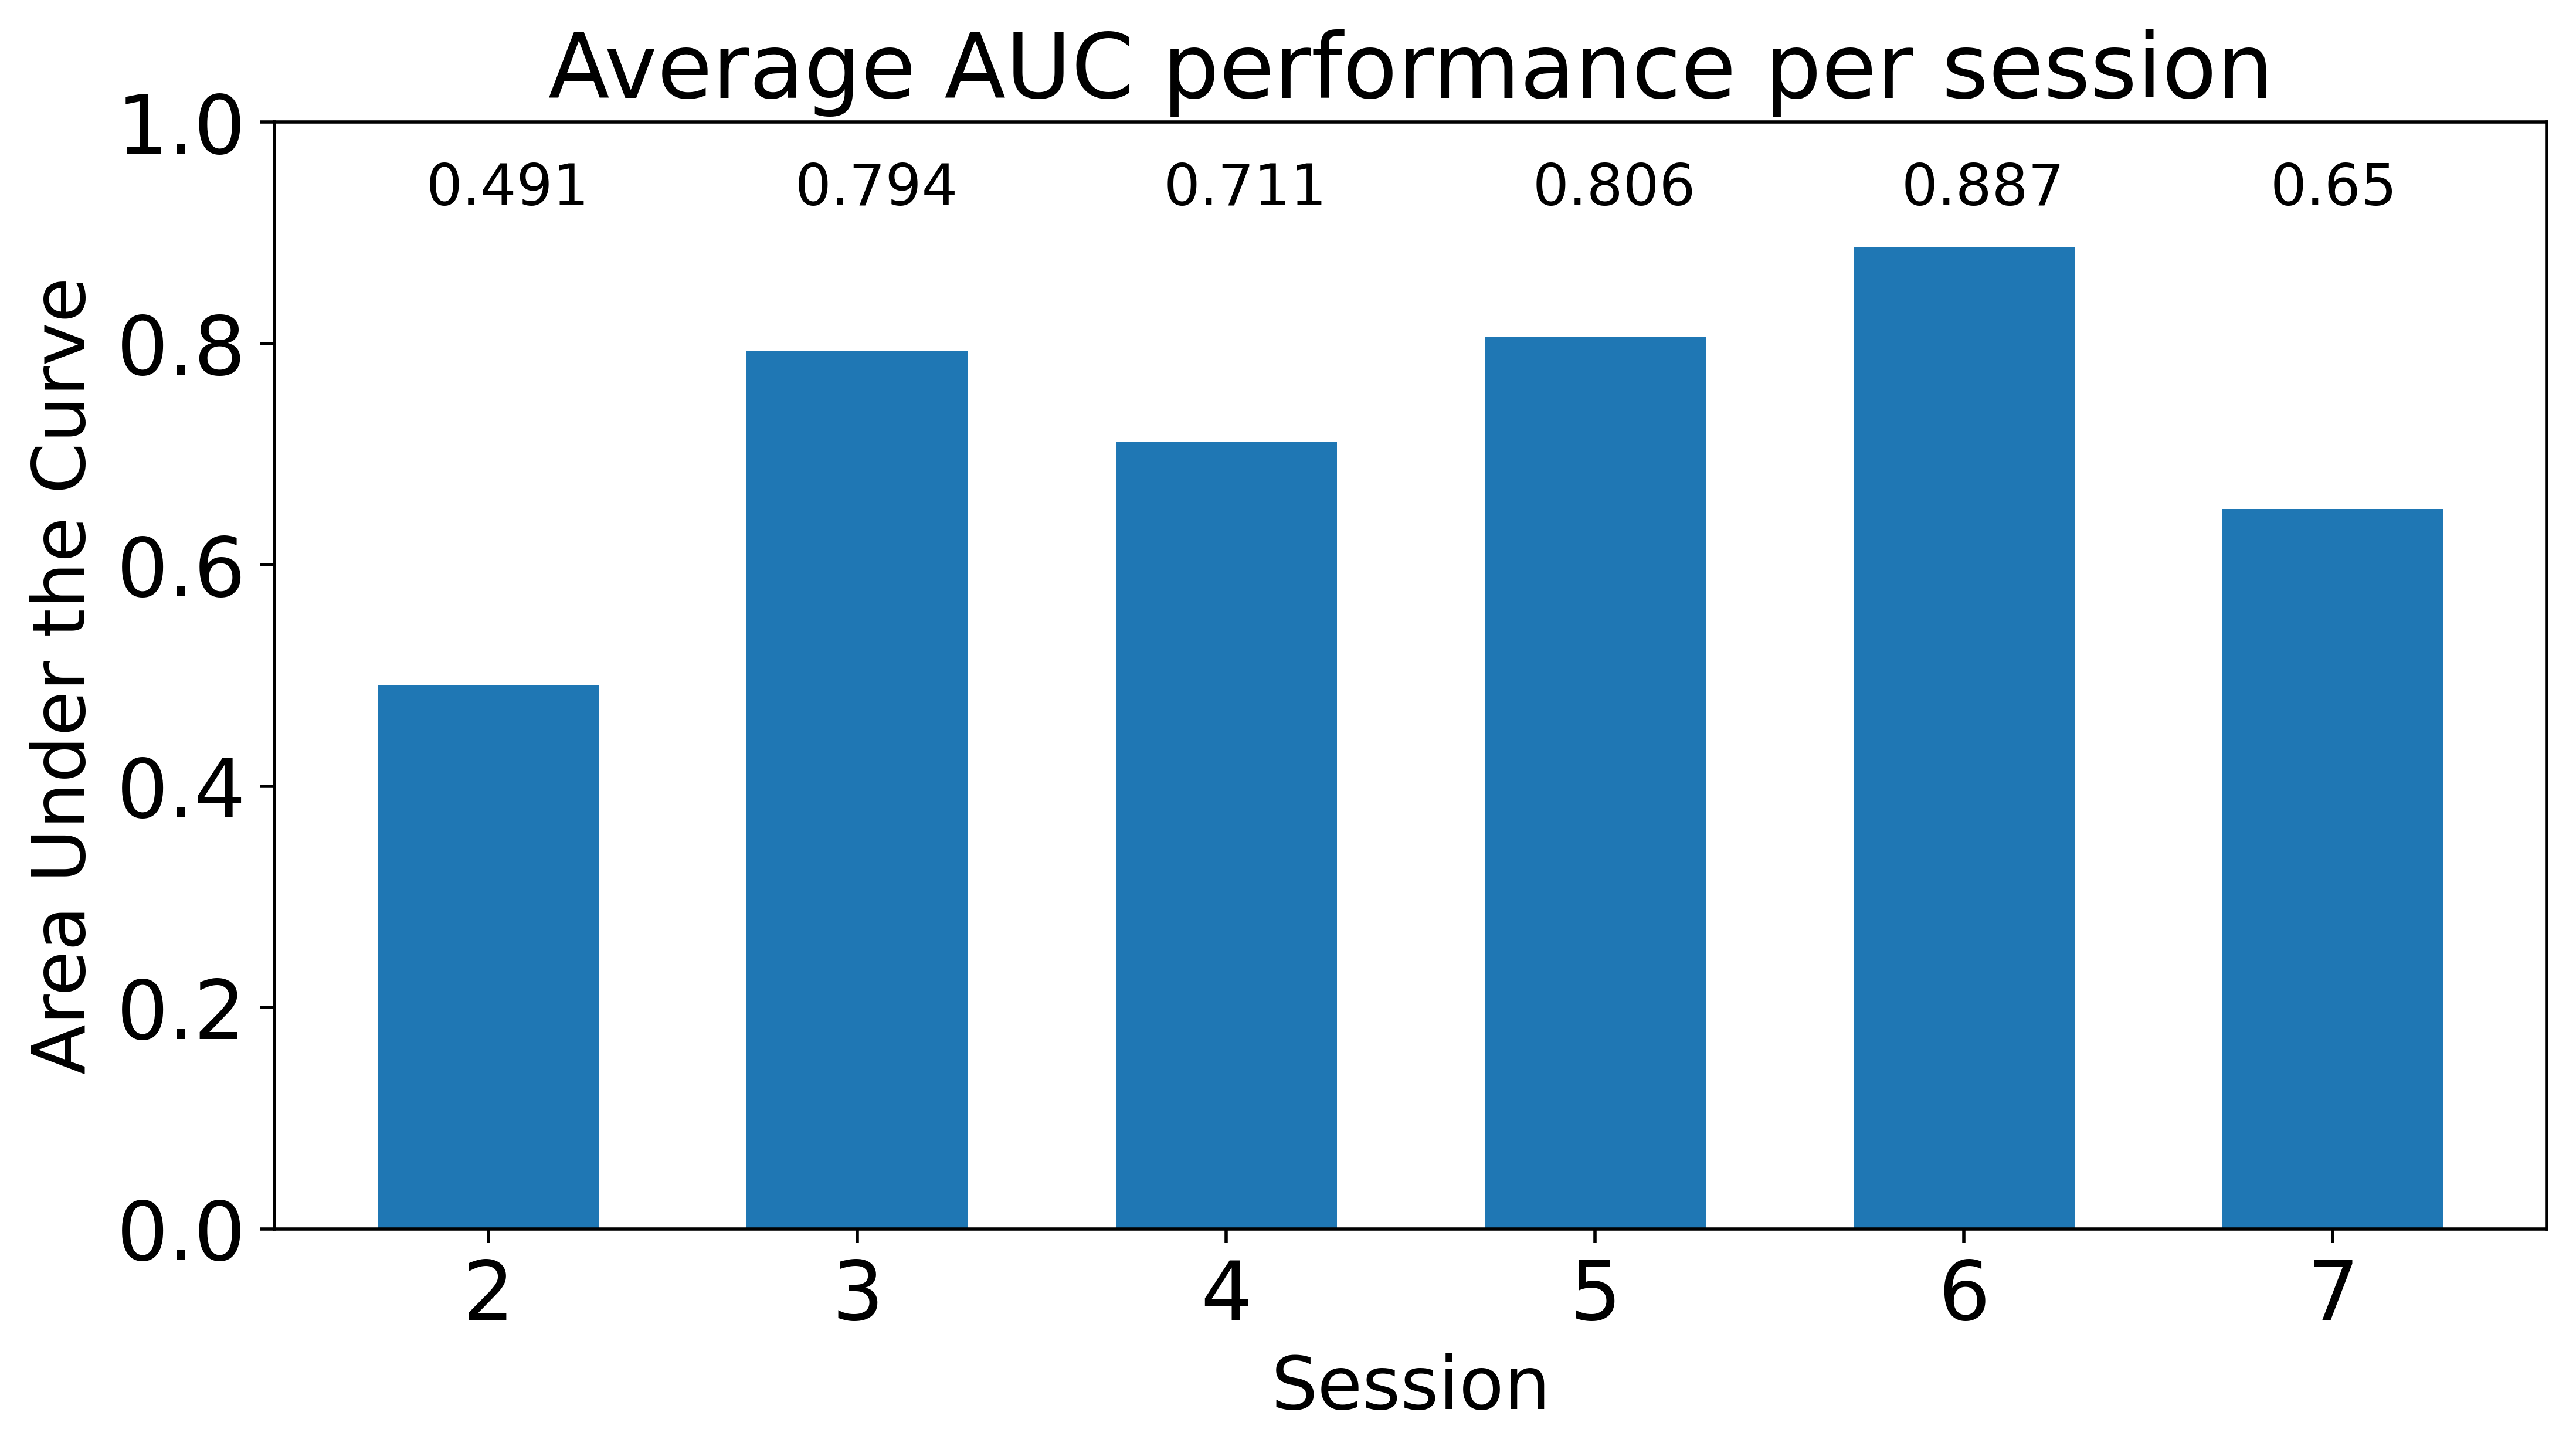

In [45]:
# plot average AUC per session
fig, ax = plt.subplots(figsize = (10,5), dpi = 500)
ax.set_ylim(0,1)
scores = sub_trial_holdout_results.drop('session', axis = 1).mean(axis=1)
ax.bar(sub_trial_holdout_results['session'], scores, 0.6)
ax.set_ylabel('Area Under the Curve', fontsize = 18)
ax.set_xlabel("Session", fontsize = 18)

for i in range(6):
    ax.text(i+2 - 0.170, 0.925, round(scores[i], 3), fontsize = 14)
ax.set_title("Average AUC performance per session", fontsize = 22)
plt.show()
fig.savefig('performances/session_comparison')

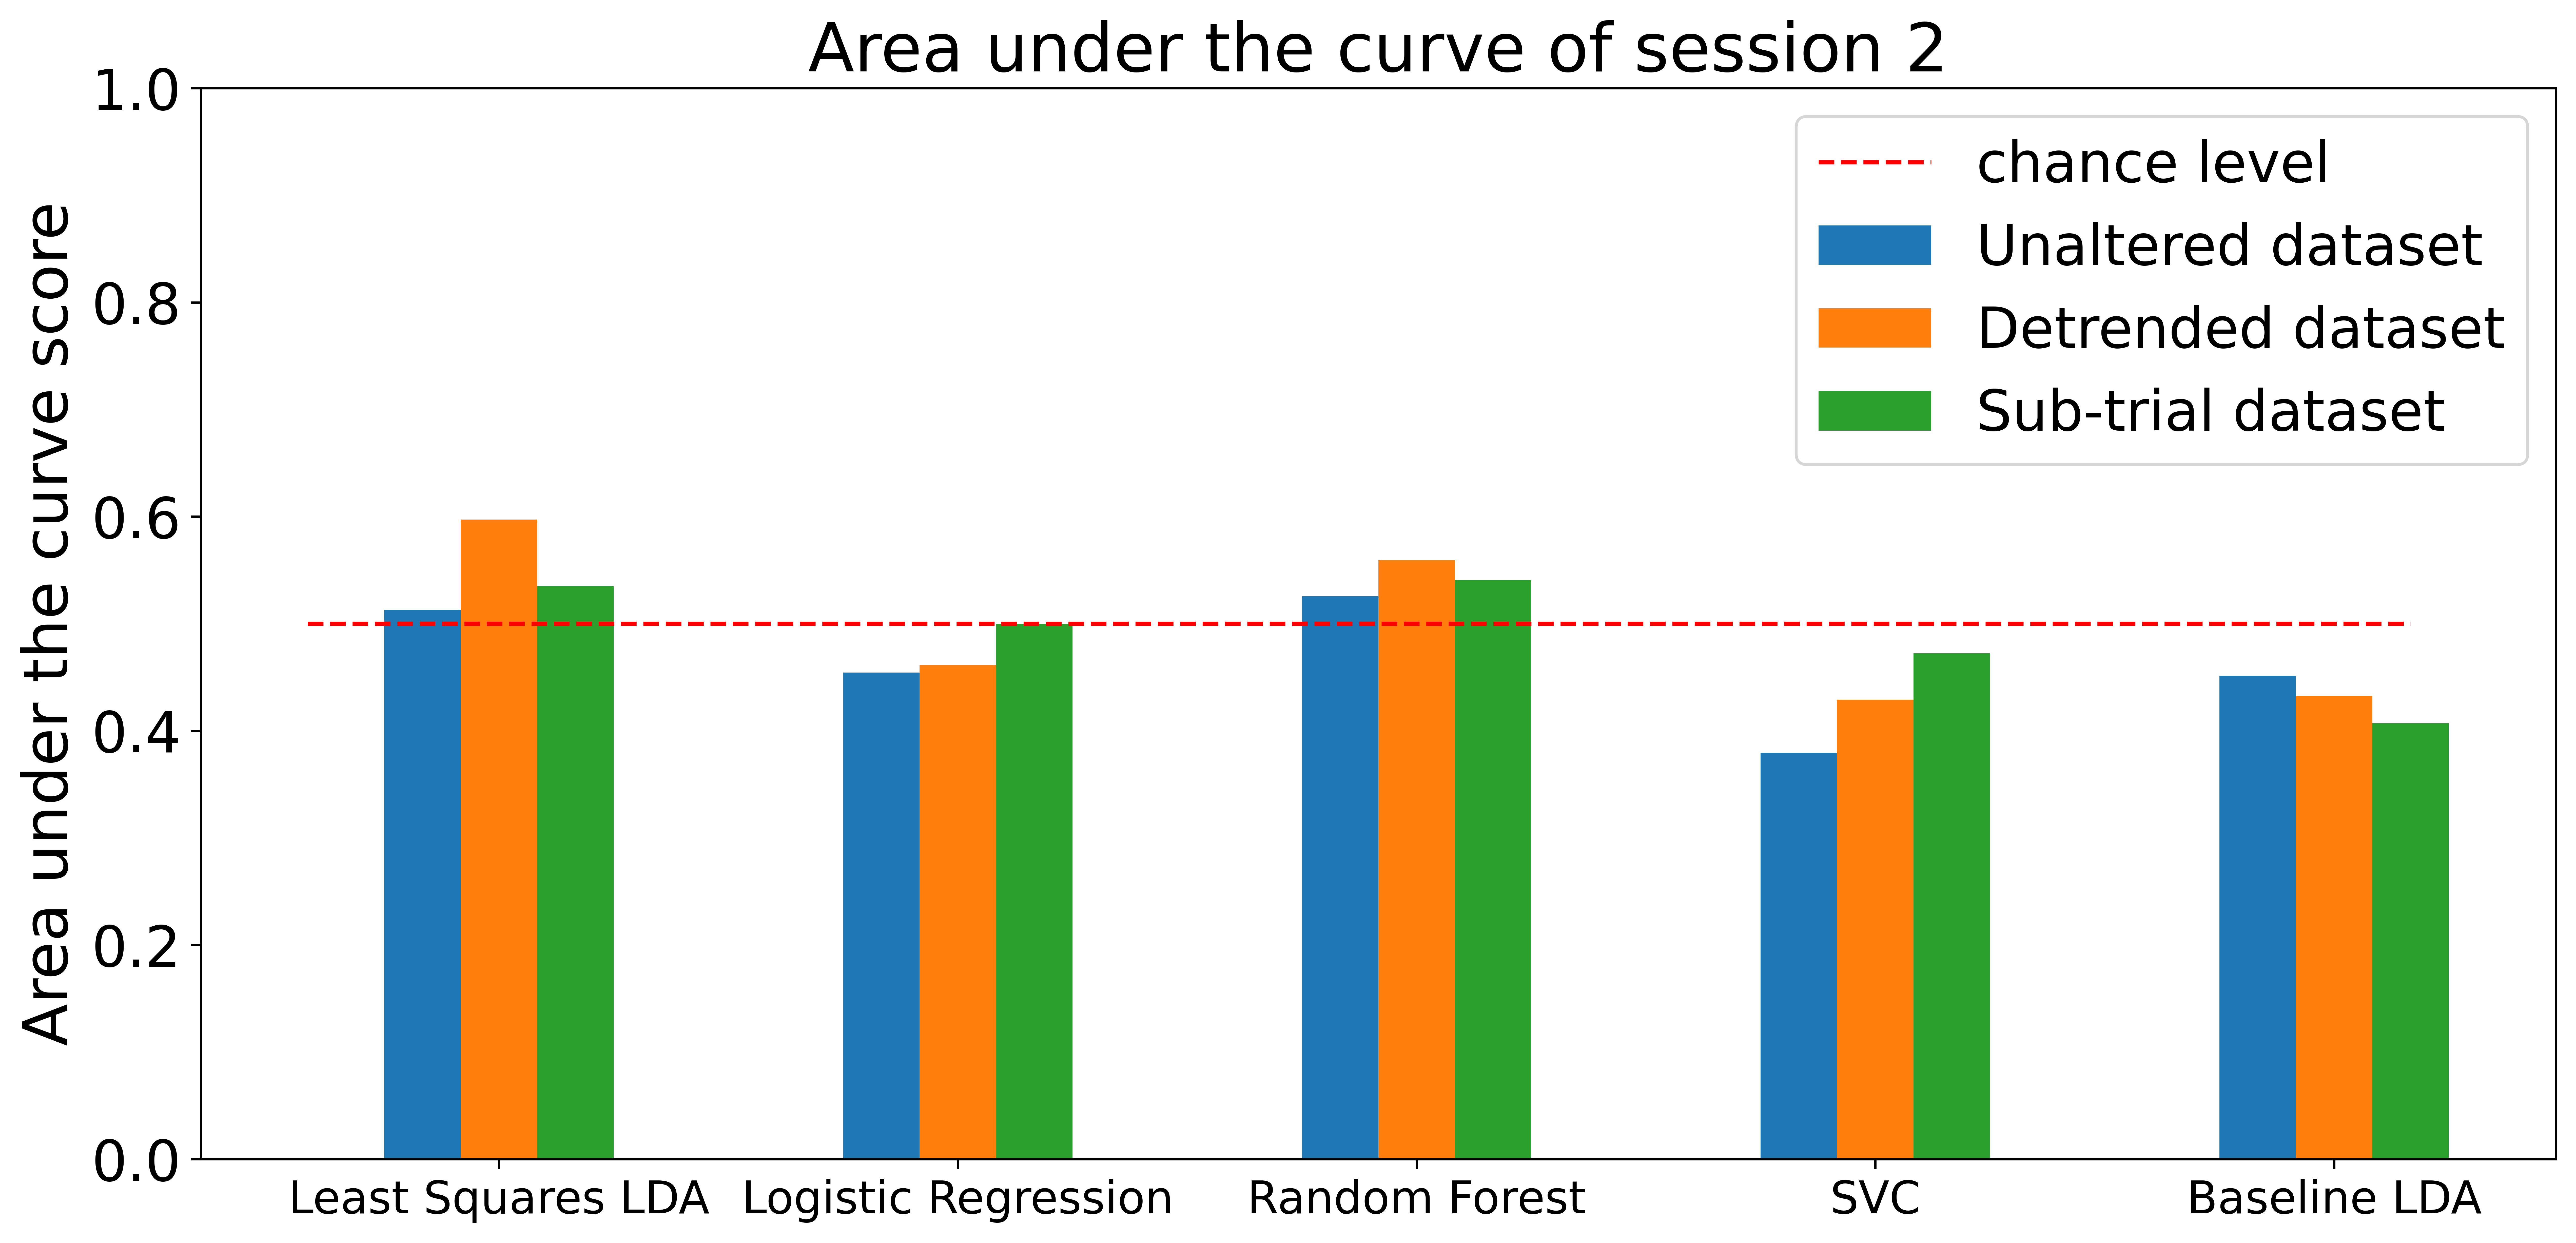

In [93]:
# plot performance of session 2
fig, ax = plt.subplots(1,1,figsize = (15, 7), dpi=800)
ax.set_ylim(0,1)
labels = ["Least Squares LDA", "Logistic Regression", "Random Forest", 
          "SVC", "Baseline LDA"]
x = np.arange(5)*1.2
width = 0.2
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 16 )
ax.bar(x - width, standard_holdout_results.iloc[0][1:], width, label= "Unaltered dataset")
ax.bar(x - width + (width), detrend_holdout_results.iloc[0][1:],  width, label= "Detrended dataset")
ax.bar(x - width + 2 *(width), sub_trial_holdout_results.iloc[0][1:],  width, label= "Sub-trial dataset")

ax.plot([-0.5,5],[0.5, 0.5], c= 'r', linestyle = '--', label = 'chance level')
ax.set_ylabel("Area under the curve score")
plt.title("Area under the curve of session 2", fontsize = 24)
plt.legend()
fig.savefig('performances/session2bad')

In [32]:

def plot_perf(df, name):
    """
    Function that plots the performance of a method on all three data-sets
    
    @param df: pandas DataFrame containing the scores on the three data-sets
    @param name: name of the method
    """
    labels = df['session'].append(pd.Series(['mean \n without  session 2']), ignore_index=True)
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize = (15,5))
    ax.set_ylabel('AUC scores')
    ax.set_xlabel('Session')
    ax.set_title(name + ' AUC scores per dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid()
    width = 0.2

    for i, col_name in enumerate(df.drop('session', axis=1).columns):
        column = df[col_name].append(pd.Series([df[col_name].iloc[1:].mean()]), ignore_index=True)

        ax.bar(x - width + i *(width), column, width, label=col_name)       
    
    
    ax.legend( loc='lower right')
    plt.show()    
    fig.savefig('performances/'+name)

## LDA results

In [8]:
data = {'session': [2,3,4,5,6,7],
        'full dataset': standard_holdout_results['LDA'],
        'detrended dataset': detrend_holdout_results['LDA'],
        'sub-trial dataset': sub_trial_holdout_results['LDA']
       }
LDA_results = pd.DataFrame(data)
LDA_results[1:].mean()

session              5.000000
full dataset         0.826898
detrended dataset    0.814479
sub-trial dataset    0.777086
dtype: float64

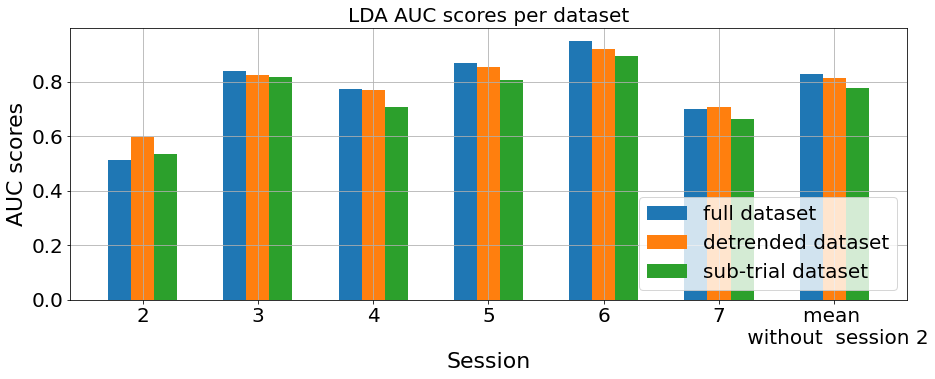

In [95]:
plot_perf(LDA_results, 'LDA')

In [7]:
data = {'session': [2,3,4,5,6,7],
        'full dataset': standard_holdout_results['Baseline LDA'],
        'detrended dataset': detrend_holdout_results['LDA transform'],
        'sub-trial dataset': sub_trial_holdout_results['LDA transform']
       }
LDA_transform_results = pd.DataFrame(data)
LDA_transform_results[1:].mean()

session              5.000000
full dataset         0.794069
detrended dataset    0.778987
sub-trial dataset    0.760120
dtype: float64

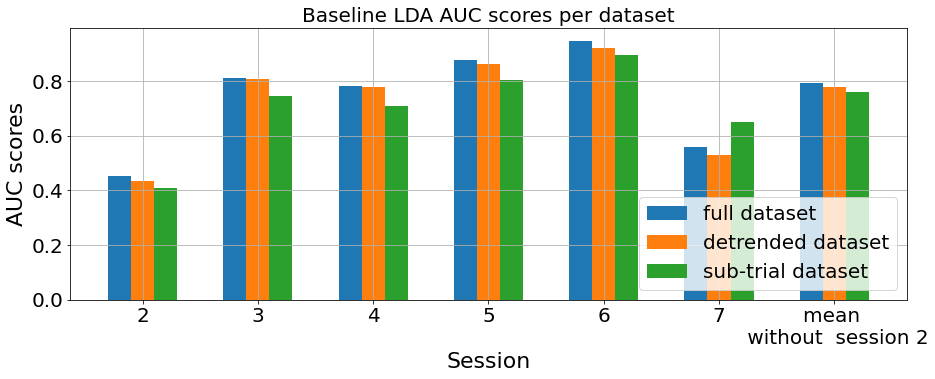

In [97]:
plot_perf(LDA_transform_results, 'Baseline LDA')

## Logistic regression results

In [9]:
data = {'session': [2,3,4,5,6,7],
        'full dataset': standard_holdout_results['Logistic Regression'],
        'detrended dataset': detrend_holdout_results['Logistic Regression'],
        'sub-trial dataset': sub_trial_holdout_results['Logistic Regression']
       }
logistic_regression_results = pd.DataFrame(data)
logistic_regression_results[1:].mean()

session              5.000000
full dataset         0.818208
detrended dataset    0.812984
sub-trial dataset    0.770563
dtype: float64

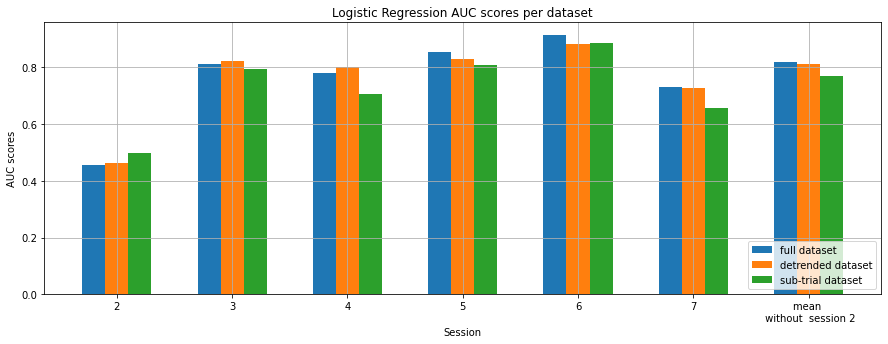

In [33]:
plot_perf(logistic_regression_results, 'Logistic Regression')

## Random forest results

In [36]:
data = {'session': [2,3,4,5,6,7],
        'full dataset': standard_holdout_results['Random Forest'],
        'detrended dataset': detrend_holdout_results['Random Forest'],
        'sub-trial dataset': sub_trial_holdout_results['Random Forest']
       }
random_forest_results = pd.DataFrame(data)
random_forest_results

,session,full dataset,detrended dataset,sub-trial dataset
0,2,0.525794,0.559524,0.541005
1,3,0.830556,0.855556,0.779321
2,4,0.848958,0.818866,0.759645
3,5,0.860243,0.837240,0.810571
4,6,0.909091,0.909181,0.877335
5,7,0.644295,0.665009,0.609279


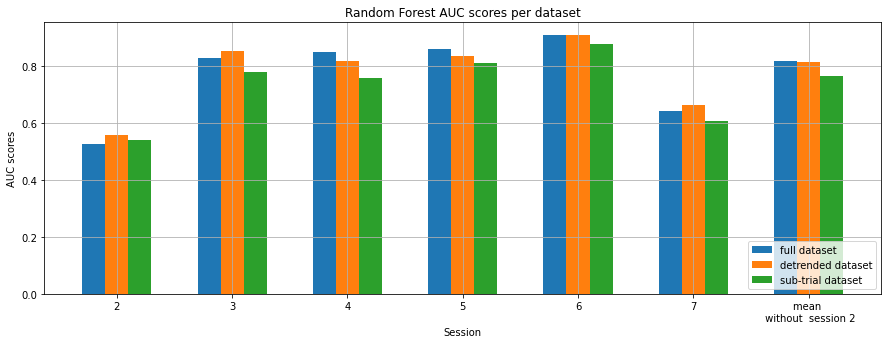

In [35]:
plot_perf(random_forest_results, 'Random Forest')

## SVC Results

In [102]:
data = {'session': [2,3,4,5,6,7],
        'full dataset': standard_holdout_results['SVC'],
        'detrended dataset': detrend_holdout_results['SVC'],
        'sub-trial dataset': sub_trial_holdout_results['SVC']
       }

svc_results = pd.DataFrame(data)
svc_results

,session,full dataset,detrended dataset,sub-trial dataset
0,2,0.379464,0.429067,0.472388
1,3,0.866667,0.851389,0.832253
2,4,0.752315,0.809028,0.671875
3,5,0.840278,0.840278,0.803144
4,6,0.915133,0.876443,0.883267
5,7,0.769137,0.796875,0.674225


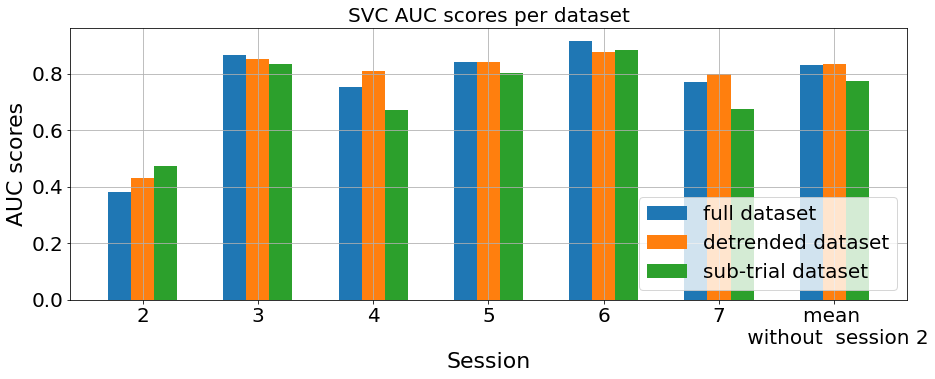

In [103]:
plot_perf(svc_results, 'SVC')

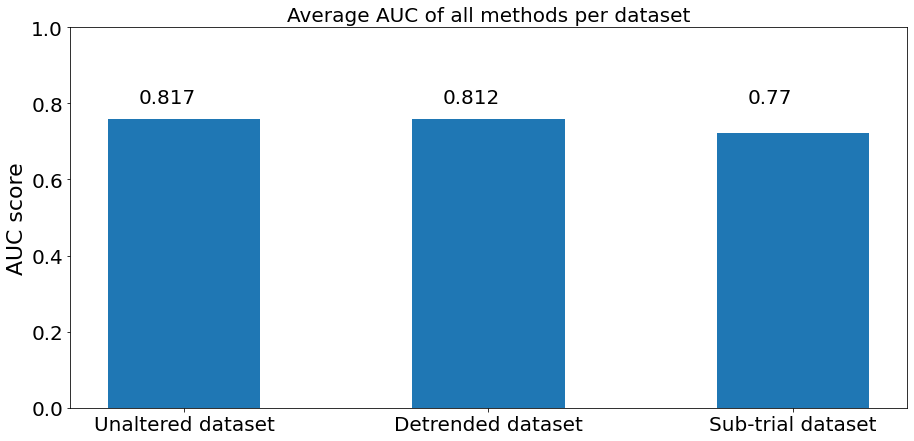

In [168]:
# plot average performance on each of the datasets
fig, ax = plt.subplots(figsize = (15,7))
labels = ['Unaltered dataset', 'Detrended dataset', 'Sub-trial dataset']
x = np.arange(len(labels))

ax.bar(0, standard_holdout_results.mean().iloc[1:].mean(), 0.5) 
ax.text(0-0.15, 0.8, str(round(standard_holdout_results.iloc[1:].mean().iloc[1:].mean(), 3)))

ax.bar(1 , detrend_holdout_results.mean().iloc[1:].mean(), 0.5, color='C0') 
ax.text(1-0.15, 0.8, str(round(detrend_holdout_results.iloc[1:].mean().iloc[1:].mean(), 3)))

ax.bar(2 , sub_trial_holdout_results.mean().iloc[1:].mean(), 0.5, color= 'C0') 
ax.text(2-0.15, 0.8, str(round(sub_trial_holdout_results.iloc[1:].mean().iloc[1:].mean(), 3)))
ax.set_title('Average AUC of all methods per dataset')
ax.set_ylabel('AUC score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1)
plt.show()
fig.savefig('performances/dataset comparison')

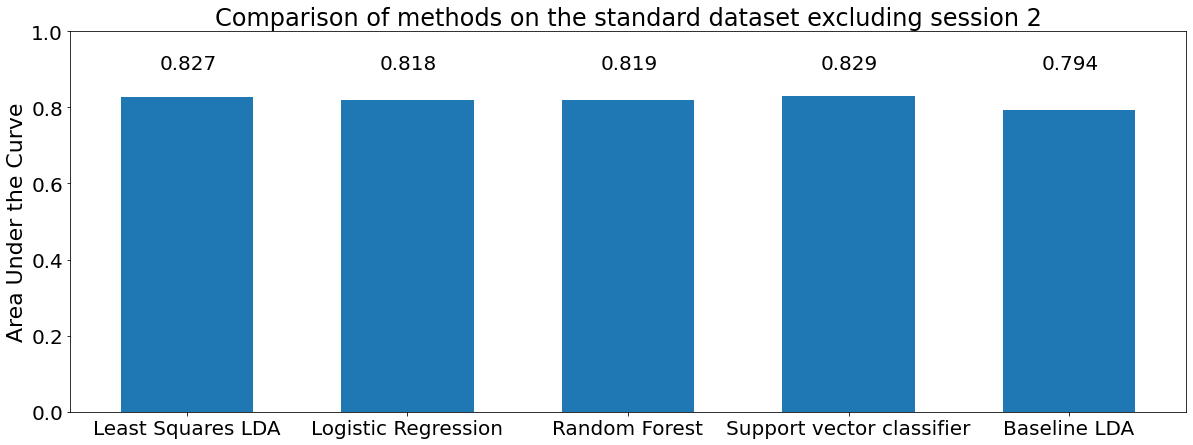

In [113]:
# plot average performance on the standard dataset per method
fig, ax = plt.subplots(figsize = (20,7))
ax.set_ylim(0,1)
ax.bar(standard_holdout_results.rename(columns = {'LDA': 'Least Squares LDA', 
                                                               'SVC': 'Support vector classifier'}).columns[1:6] 
       ,standard_holdout_results[1:].mean()[1:6], 0.6)
ax.set_ylabel('Area Under the Curve')
for i in range(5):
    ax.text(i - 0.125, 0.9, round(standard_holdout_results.iloc[1:].mean()[1:6][i], 3))
ax.set_title("Comparison of methods on the standard dataset excluding session 2", fontsize = 24)
plt.show()
fig.savefig('performances/performance comparison')

In [7]:
# perform wilcoxon test whether the baseline significantly differs from SVC
from scipy.stats import wilcoxon
baseline_scores = np.concatenate(standard_lda_transform['holdout_scores'].values[1:].tolist())
svc_scores =  np.concatenate(standard_svc['holdout_scores'].values[1:].tolist())


wilcoxon(baseline_scores, svc_scores)

WilcoxonResult(statistic=234.5, pvalue=0.5811517680947831)

In [67]:
# results on the standard dataset
s = standard_holdout_results[1:].copy()
s = s.rename(columns = {'LDA transform': "Baseline LDA"})
s.loc['mean'] = s.mean()
s.loc['mean']['session'] = 'mean'
s

,session,LDA,Logistic Regression,Random Forest,SVC,Baseline LDA
1,3.0,0.840278,0.813889,0.830556,0.866667,0.809722
2,4.0,0.774306,0.780093,0.848958,0.752315,0.782407
3,5.0,0.869792,0.853299,0.860243,0.840278,0.875000
4,6.0,0.949044,0.913330,0.909091,0.915133,0.946158
5,7.0,0.701073,0.730429,0.644295,0.769137,0.557055
mean,5.0,0.826898,0.818208,0.818628,0.828706,0.794069


In [58]:
# results on the detrended data-set
s = detrend_holdout_results[1:].copy()
s = s.rename(columns = {'LDA transform': "Baseline LDA"})
s.loc['mean'] = s.mean()
s.loc['mean']['session'] = 'mean'
s

,session,LDA,Logistic Regression,Random Forest,SVC,Baseline LDA
1,3.0,0.825000,0.822222,0.855556,0.851389,0.806944
2,4.0,0.767361,0.800926,0.818866,0.809028,0.776620
3,5.0,0.854167,0.829861,0.837240,0.840278,0.860243
4,6.0,0.917929,0.883297,0.909181,0.876443,0.920905
5,7.0,0.707939,0.728614,0.665009,0.796875,0.530224
mean,5.0,0.814479,0.812984,0.817170,0.834802,0.778987


In [59]:
# results on the sub_trial data-set
s = sub_trial_holdout_results[1:].copy()
s = s.rename(columns = {'LDA transform': "Baseline LDA"})
s.loc['mean'] = s.mean()
s.loc['mean']['session'] = 'mean'
s

,session,LDA,Logistic Regression,Random Forest,SVC,Baseline LDA
1,3.0,0.816204,0.795679,0.779321,0.832253,0.744290
2,4.0,0.708462,0.706276,0.759645,0.671875,0.706919
3,5.0,0.804109,0.807292,0.810571,0.803144,0.805073
4,6.0,0.895102,0.886133,0.877335,0.883267,0.895072
5,7.0,0.661555,0.657434,0.609279,0.674225,0.649244
mean,5.0,0.777086,0.770563,0.767230,0.772953,0.760120


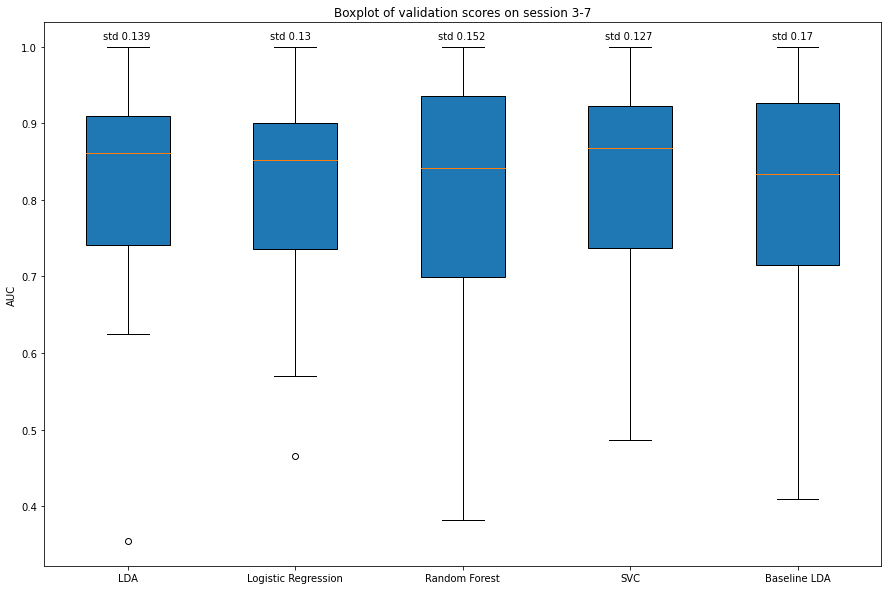

In [13]:
# plot boxplots of holdout results per method
import  operator as op

plot_data = { 
        'LDA': np.concatenate(standard_lda['holdout_scores'].values[1:]),
       'Logistic Regression': np.concatenate(standard_lr['holdout_scores'].values[1:]),
       'Random Forest': np.concatenate(standard_rf['holdout_scores'].values[1:]),
       'SVC': np.concatenate(standard_svc['holdout_scores'].values[1:]),
       'Baseline LDA': np.concatenate(standard_lda_transform['holdout_scores'].values[1:])
       }


fig, ax = plt.subplots(figsize =(15,10))
ax.boxplot(plot_data.values(),patch_artist=True)
ax.set_xticklabels(plot_data.keys())
ax.set_title("Boxplot of validation scores on session 3-7")
ax.set_ylabel('AUC')


for i in range(5):
    ax.text(i+0.85, 1.01, "std " + str(round(np.std(list(plot_data.values()), axis = 1)[i], 3)))
fig.savefig('performances/performance boxplot')
plt.show()


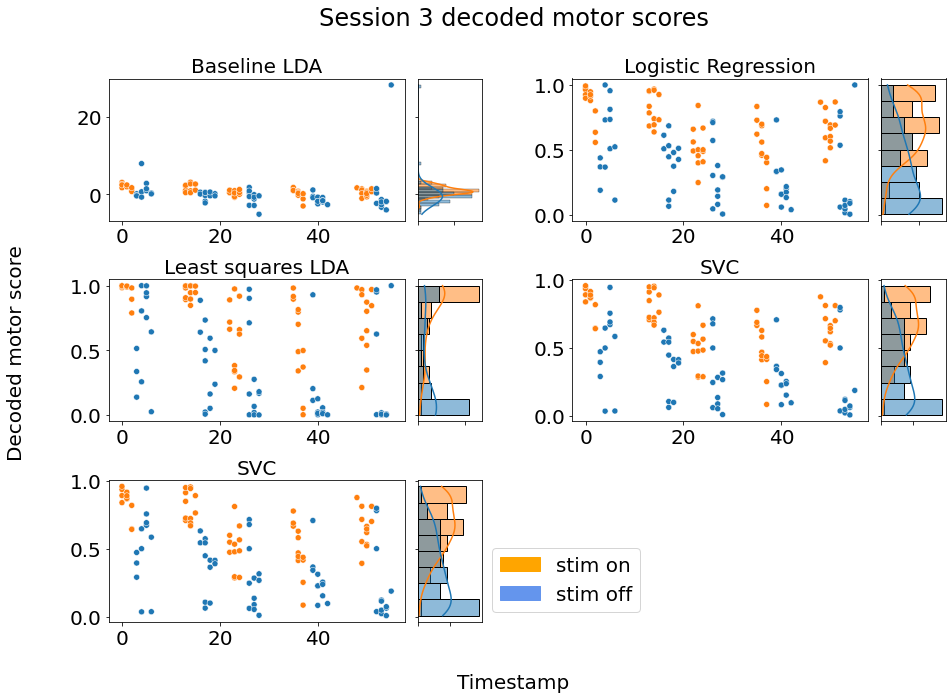

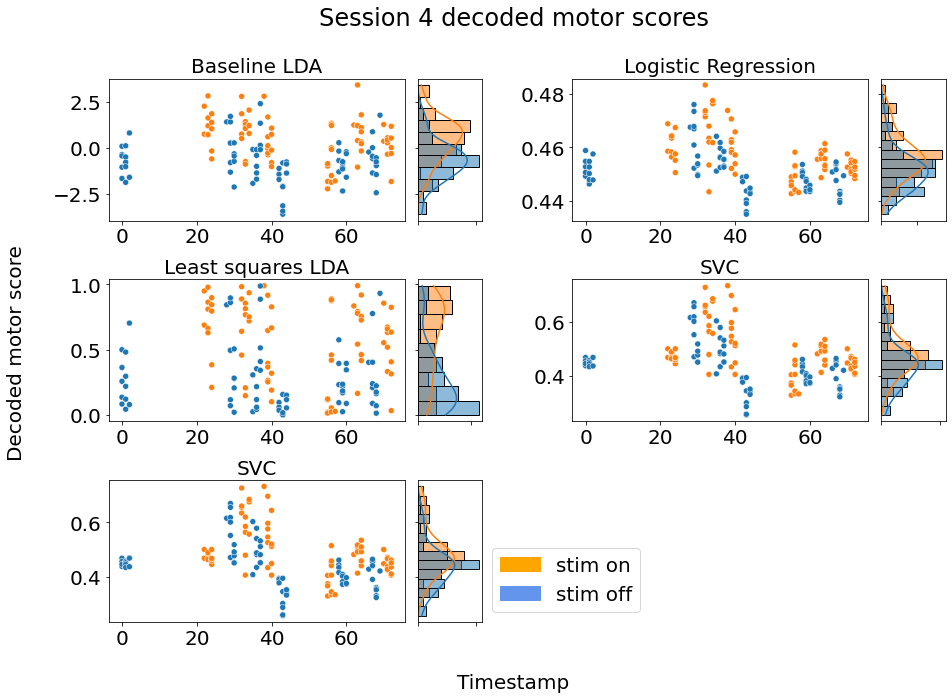

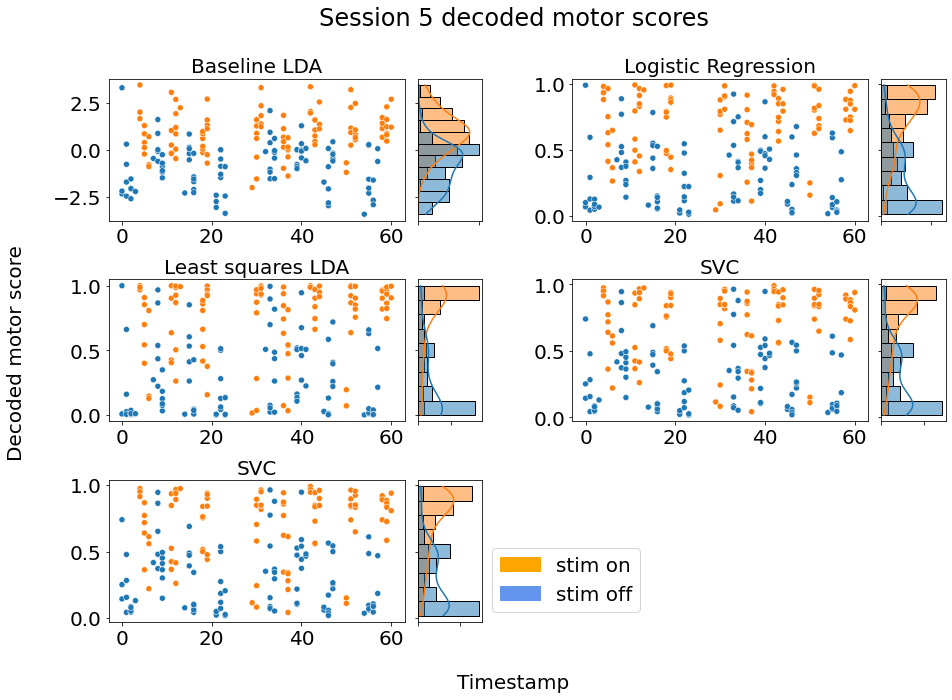

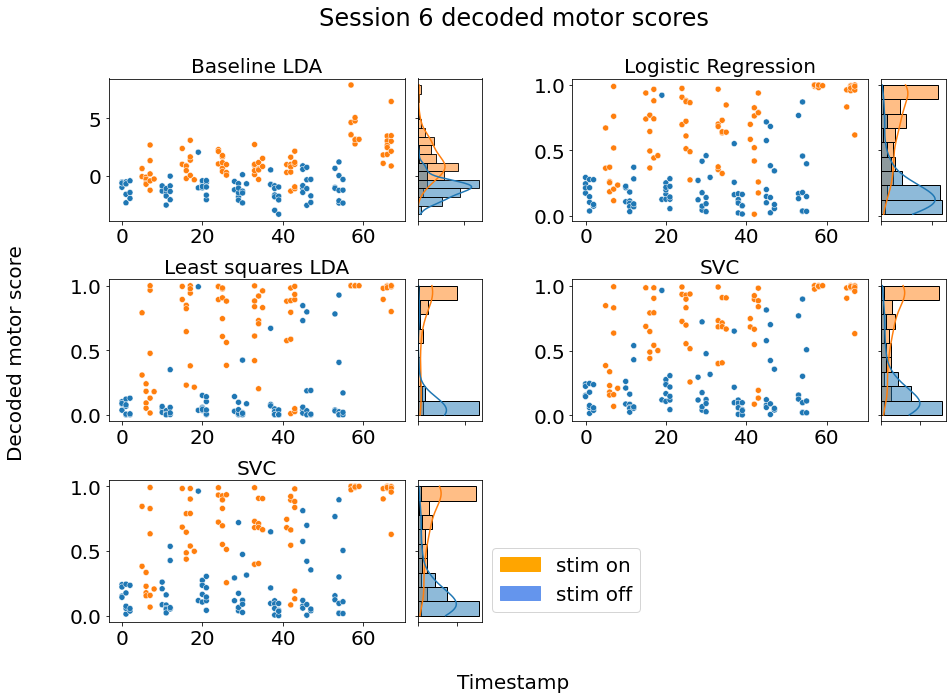

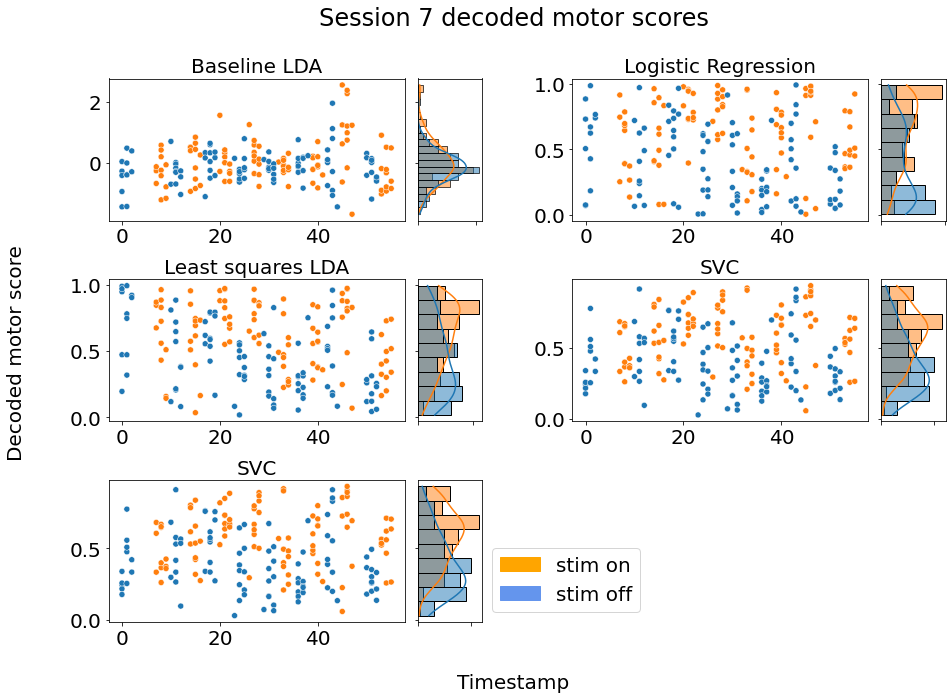

In [167]:
# Plot the decoded motor scores over time with a marginal distribution
kf = CustomSplitter()

lr_params = get_best_params(standard_lr_searches)
baseline_params = get_best_params(standard_lda_transform_searches)
lda_params = get_best_params(standard_lda_searches)
svc_params = get_best_params(standard_svc_searches)
rf_params = get_best_params(standard_rf_searches)

for i in range(3,8):
    data = whole_df[whole_df['session'] == i]
    lr_predictions = []
    stim = []    
    baseline_predictions = []
    lda_predictions = []
    rf_predictions = []
    svc_predictions = []
    tstamps = []
    fig= plt.figure(figsize = (15, 10))

    gs = GridSpec(11,11)
    
    for train_index, test_index in kf.split(data):    
    
        X = data.iloc[train_index].drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp'], axis =1)
        y  = data.iloc[train_index]['stim']
        
        X_test = data.iloc[test_index].drop(['session', 'ix_block', 'ix_trial', 'stim', 'startTStamp'], axis =1)        
        
        y_test = data.iloc[test_index]['stim']
        
        
        tstamps = np.append(tstamps, data.iloc[test_index]['startTStamp'])
        stim = np.append(stim, y_test)
                
        lr_pipeline = pipeline = Pipeline([('standardize', StandardScaler()),
                             ('classifier', LogisticRegression())]).set_params(**lr_params[i])        
        
        baseline_pipeline = Pipeline([('standardize', StandardScaler()),
                                     ('classifier', LDA())]).set_params(**baseline_params[i])
        
        lda_pipeline = Pipeline([('standardize', StandardScaler()),                                      
                                     ('classifier', LDA())]).set_params(**lda_params[i])
        
        rf_pipeline = Pipeline([('classifier', 
                                 RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators=128))]).set_params(**rf_params[i])  
        
        svc_pipeline = Pipeline([('standardize', StandardScaler()),
                                     ('classifier', SVC(probability = True, random_state = 42))]).set_params(**svc_params[i])  
        
        lr_pipeline.fit(X, y)
        baseline_pipeline.fit(X, y)    
        lda_pipeline.fit(X, y) 
        rf_pipeline.fit(X, y)
        svc_pipeline.fit(X, y)
        
        if np.mean(baseline_pipeline.transform(X[y==0])) > np.mean(baseline_pipeline.transform(X[y==1])):           
            baseline_predictions = np.append(baseline_predictions, baseline_pipeline.transform(X_test) * -1) 
        else:       
            baseline_predictions = np.append(baseline_predictions, baseline_pipeline.transform(X_test))        
        
        lr_predictions = np.append(lr_predictions, lr_pipeline.predict_proba(X_test)[:,1])       
        lda_predictions = np.append(lda_predictions, lda_pipeline.predict_proba(X_test)[:,1])
        rf_predictions = np.append(rf_predictions, rf_pipeline.predict_proba(X_test)[:,1])
        svc_predictions = np.append(svc_predictions, svc_pipeline.predict_proba(X_test)[:,1])
    
    #baseline 
    ax_joint = fig.add_subplot(gs[0:3,0:4])
    ax_marg_y = fig.add_subplot(gs[0:3,4])
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_joint.set_title('Baseline LDA')

    sns.scatterplot(y = baseline_predictions, x=tstamps  ,hue = stim, ax = ax_joint, legend = False)
    sns.histplot(y = baseline_predictions, hue = stim, kde = True, ax = ax_marg_y, legend = False)

    #logistic regression
    ax_joint = fig.add_subplot(gs[0:3,6:10])
    ax_marg_y = fig.add_subplot(gs[0:3,10])
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_joint.set_title('Logistic Regression')

    sns.scatterplot(y = lr_predictions, x=tstamps  ,hue = stim, ax = ax_joint, legend = False)
    sns.histplot(y = lr_predictions, hue = stim, kde = True, ax = ax_marg_y, legend = False)
    
    #lsqr lda
    ax_joint = fig.add_subplot(gs[4:7,0:4])
    ax_marg_y = fig.add_subplot(gs[4:7,4])
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_joint.set_title('Least squares LDA')

    sns.scatterplot(y = lda_predictions, x=tstamps  ,hue = stim, ax = ax_joint, legend = False)
    sns.histplot(y = lda_predictions, hue = stim, kde = True, ax = ax_marg_y, legend = False)        
    
    #svc
    ax_joint = fig.add_subplot(gs[4:7,6:10])
    ax_marg_y = fig.add_subplot(gs[4:7,10])
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_joint.set_title('SVC')

    sns.scatterplot(y = svc_predictions, x=tstamps  ,hue = stim, ax = ax_joint, legend = False)
    sns.histplot(y = svc_predictions, hue = stim, kde = True, ax = ax_marg_y, legend = False)   
    
    #svc
    ax_joint = fig.add_subplot(gs[8:11,0:4])
    ax_marg_y = fig.add_subplot(gs[8:11,4])
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_joint.set_title('SVC')

    sns.scatterplot(y = svc_predictions, x=tstamps  ,hue = stim, ax = ax_joint, legend = False)
    sns.histplot(y = svc_predictions, hue = stim, kde = True, ax = ax_marg_y, legend = False)
    orange_patch = mpatches.Patch(color='orange', label = 'stim on')
    blue_patch = mpatches.Patch(color='cornflowerblue', label = 'stim off')
    plt.legend(handles = [orange_patch, blue_patch], bbox_to_anchor=(1,0), loc='lower left')
    fig.text(0.5, 0.04, 'Timestamp', ha='center', va='center')
    fig.text(0.04, 0.5, 'Decoded motor score', ha='center', va='center', rotation='vertical')
    fig.suptitle('Session '+ str(i) + ' decoded motor scores')
    fig.savefig('motor scores/Session'+ str(i) + 'decoded motor scores')
    plt.show()


In [70]:
import dill
dill.dump_session('Method_eval.db')